# Solving the 1D Swift-Hohenberg Equation

This file implements the Physics Informed Neural Networks (PINN) class written by Maziar Raissi and modifies them to apply to the Swift-Hohenberg equation. Please refer to the following for more information:  https://github.com/maziarraissi/PINNs

## Set Up and Introduction 
The Swift-Hohenberg equation 
$$u_t = -(1+\Delta)^2 u - \mu u + \nu u^2 - u^3 $$
was derived in 1977 by Swift and Hohenberg to study thermal fluctuations of a fluid. We will be interested in the 1 dimensional Swift-Hohenberg equation, meaning $u = u(x,t)$ with $x,t \in \mathbb R$. 

In particular, we will train a deep neural network to predict the dynamics of the solution $u$. The training data will be unperturbed and the model will be initialized with both the PDE and the parameters. We run three experiments; the first with training data sampled only from the boundary of the domain, the second with training data sampled from the interior of the domain and the last with training data sampled from both the interior and the boundary of the domain.

It is important to note that this file uses version 1.14 of Tensorflow and Python 3.7 and will not be compatible with newer versions. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import scipy.io
import scipy.stats
from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

import PhysicsInformedNN1 as NN

In [2]:
np.random.seed(1234)
tf.set_random_seed(1234)

import sys
sys.path.insert(0, '../../Utilities/')

Check and configure the file path here.

In [3]:
ls

Burger_discover_exact.pdf           SH_1Dtf26.ipynb
Burger_discover_pred.pdf            SH_mat.m
Burger_exact.pdf                    SH_mat2.asv
Burger_predict.pdf                  SH_mat2.m
Burger_slice.pdf                    SolvingSH1D-Class.ipynb
HD_rolls_1_1_discover.pdf           Untitled.ipynb
HD_rolls_1_1_discover.png           Untitled1.ipynb
HD_rolls_1_1_discover_bad.png       __pycache__/
HD_rolls_1_2_discover.png           burger_final.ipynb
HD_rolls_1_2_discover_bad.pdf       burgers_shock.mat
HD_rolls_1_int_slice.png            cylinder_nektar_wake.mat
HD_rolls_1_mix_slice.png            data/
HD_rolls_1_pred.png                 pdfHD_rolls_1_1_discover_exact.pdf
HD_rolls_1_pred_int.png             pdfHD_rolls_1_pred.pdf
HD_rolls_1_pred_mix.png             pdfHD_rolls_1_slice.pdf
HD_rolls_1_pred_noise.png           pdfHD_rolls_1_true.pdf
HD_rolls_1_pred_noise_slice.png     pred_burger.ipynb
HD_rolls_1_slice.png                sh_rolls_test.mat
HD_rolls_1_true.png         

## Prediction

In this section, we will work with unperturbed data only. The initial value problem we will be interested in as as follows: 

\begin{align*}u_t & = -u_{xxxx} - 2 u_{xx} +(-1+\mu)u + \nu u^2 - u^3, \qquad\qquad x \in [0,20], \quad t \in [0,5] \\
u(0,x) & = \exp \left\{-(x-10)^2  \right\}. 
\end{align*}
Define
\begin{align*}
f(u) & = u_t + \mathcal N(u)\\
 & = u_t+u_{xxxx} + 2 u_{xx} -(-1+\mu)u - \nu u^2 + u^3.
\end{align*}

We fix $\mu = 1$ and $\nu = 1.2$. Intuitively, the parameter $\mu$ measures how far the temperature is above the minimum temperature required for convection.

### Approximating $u(t,x)$ via Boundary Data
We now work to approximate $u(t,x)$ with the parameters known and fixed using a deep neural network. First, we only sample training data from the boundary of the spatiotemporal domain. 

#### Data Preprocessing
First, we initialize the parameters and load the data. This data was generated via the matlab file titled 'sh_1d.m' and contains values for the solution $u(x,t)$ at $N = 512$ points in the spatial domain and $T = 201$ points in the temporal domain. The snapshots are $\Delta t = .025$ apart. 

In particular, we used a Fourier discretization with $250$ modes and a fourth order Runge-Kutta temporal integrator with time step size $10^{-4}$ within the Chebfun package.

In [4]:
# load the data
# data is a dictionary
data = scipy.io.loadmat("data/exp1d_HD.mat")

# set the parameter values
mu=1
nu=1.2

This is a multidimensional array containing $(x,t)$ values and solution values, $u(x,t)$ obtained using Chebfun in Matlab. 

The data vaThe spatial variable $x$ is under the key 'spatial_vec', the temporal variable $t$ is under the key 't_span' and the value of the solution $u(x,t)$ is under the key 'data'.

In [5]:
print('The keys are:', sorted(data.keys()))
print('The size of ''tspan'':', np.shape(data['tspan']))
print('The size of ''data'':', np.shape(data['data']))
print('The size of ''spatial_vec'':', np.shape(data['spatial_vec']))

The keys are: ['__globals__', '__header__', '__version__', 'data', 'spatial_vec', 'tspan']
The size of tspan: (1, 201)
The size of data: (512, 201)
The size of spatial_vec: (1, 512)


Now we work to format the initial data. 

In [6]:
## Extract the values for x and t
t = data['tspan'].flatten()[:,None]
x = data['spatial_vec'].flatten()[:,None]
# Extract the solution values
true_sol = np.real(data['data']).T

# Construct a coordinate grid for the domain data
X,T = np.meshgrid(x,t)

In [7]:
# Formats the domain data as a column vector with rows of the form (x,t)
domain_col = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_col = true_sol.flatten()[:,None]              

# Get domain bounds in the form (x,t)
lb = domain_col.min(0)
ub = domain_col.max(0) 

print('Lower bound (x,t): ', lb)
print('Upper bound (x,t): ', ub)

Lower bound (x,t):  [0. 0.]
Upper bound (x,t):  [20.  5.]


#### Initialize Neural Network
Now we initialize the NN architecture. We choose $N_u + N_f$ total points in the training data, where $N_u$ is the number of initial and boundary data for the solution $u(x,t)$ and $N_f$ is the number of collocation points. The collocation points train the neural network to satisfy the PDE while the data for the solution trains the neural network to match the numerically solved solution. If the intial and boundary data is denoted as $\{(t_{u,i}, x_{u,i}, u_i)\}_{i=1}^{N_u}$, the collocation points are given by $\{(t_f{f,i}, x_{f,i})\}_{i=1}^{N_f}$ and the prediction by the NN is denoted as $\hat u$, then the mean squared error is given by 
\begin{align*} MSE & = MSE_u + MSE_f \\
& = \frac{1}{N_u}\sum_{i=1}^{N_u} \left\| \hat u(t_{u,i}, x_{u,i}) - u_i\right\|^2 \\
& \qquad + \frac{1}{N_f} \sum_{i=1}^{N_f} \left\|\hat u_t(t_{f,i}, x_{f,i}) - \mathcal N\left(\hat u (t_{f,i}, x_{f,i} \right) \right\|^2.
\end{align*}

We initially choose $200$ training points, $10000$ collocation points and $8$ hidden layers with $20$ nodes in each layer. 

In [8]:
# Set number of training points, collocation points and layers/neurons
N_u = 200
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

We initialize our initial conditions and boundary data. The initial condition, the boundary data, and the collocation points together form our training data. 

In [9]:
# Extract the boundary data. This corresponds to (0,x), (t,0), (t,20)
ic1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
u1 = true_sol[0:1,:].T
ic2 = np.hstack((X[:,0:1], T[:,0:1]))
u2 = true_sol[:,0:1]
ic3 = np.hstack((X[:,-1:], T[:,-1:]))
u3 = true_sol[:,-1:]

# Define the training data from the boundary data and randomly selected collocation points (also on the boundary)
X_u_train = np.vstack([ic1, ic2, ic3])
u_train = np.vstack([u1, u2, u3])

X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))

Now we randomly sample $N_u$ points for our training data. 

In [10]:
# Randomly generate N_u indices. These correspond to our training data.
indices = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[indices, :]
u_train = u_train[indices,:]

Now we can initialize our model. 

In [11]:
# initialize the model using the PINN class
model = NN.PINN(X_u_train, u_train, X_f_train, layers, lb, ub, mu, nu, False)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



#### Train Neural Network
Now we train the model. Note that the data is not noisy and we know the parameter values. 

In [12]:
# Train the model. We pass in 0 because our data is not noisy, so we do not want to iterate with the Adam optimizer
# We pass in False because we know mu, nu and we do not want the NN to predict them.
model.train(0, False)

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.008640
  Number of iterations: 5577
  Number of functions evaluations: 6085


Now we can predict the value of the function $u(x,t)$ on the entire domain $[0,1] \times [-1,1]$. The relative error of our model $\hat u$ is defined to be 
$$ \text{RelError}(u, \hat u) =  \sum_{i} \frac{\|u(t_i,x_i) - \hat u(t_i,x_i)\|}{\|u(t_i,x_i)\|}.  $$

#### Results: Predicting Dynamics
We only trained the model on the boundary of the spatio-temporal domain. We would like to see how it does in predicting the dynamics both on the boundary and on the interior of the domain. 

In [13]:
# Predict the value of u and f on the entire domain. We want f to be close to 0 everywhere and u_pred to be close to the true u
u_pred_all, f_pred = model.predict(domain_col, False)

In [14]:
# print the errors
error_u = np.linalg.norm(u_col-u_pred_all,2)
print('Relative Error of u: %e' % (error_u/np.linalg.norm(u_col,2)))
print('Error of u: %e' % (error_u))

u_pred = griddata(domain_col, u_pred_all.flatten(), (X,T), method='cubic')
error = np.abs(true_sol - u_pred)
max_error=np.amax(error)
print('The largest pointwise error is %e' % (max_error))

Relative Error of u: 8.890427e-01
Error of u: 2.282167e+02
The largest pointwise error is 1.760057e+00


We can also plot $\hat u(x,t)$ along with $u(x,t)$. We plot time $t$ on the horizontal axis and the spatial variable $x$ on the horizontal axis. The value of $\hat u(x,t)$ and $u(x,t)$ are represented via a color map. 

Our learned model identifies the central roll in the dynamics but fails to predict the appearance of the other two rolls. 

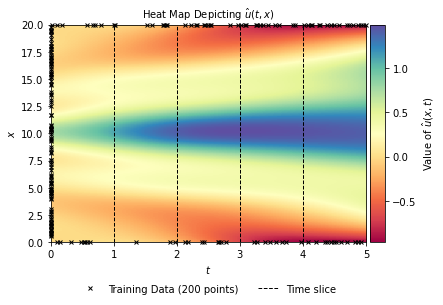

In [15]:
# intialize the figure and axis object
fig, ax = plt.subplots()

# This creates the color map for the predictions
h = ax.imshow(u_pred.T, interpolation='nearest', cmap='Spectral', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
# add a legend for the colors
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(h,cax=cax)
cbar.ax.set_ylabel('Value of $\hat u(x,t)$')

# Plot the training data (boundary data)
ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Training Data (%d points)' % (u_train.shape[0]), markersize=4,  clip_on = False)

# Plot lines corresponding to the triptych below
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[40]*np.ones((2,1)), line, 'k--', linewidth = 1, label = 'Time slice')
ax.plot(t[80]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[120]*np.ones((2,1)), line, 'k--', linewidth = 1)   
ax.plot(t[160]*np.ones((2,1)), line, 'k--', linewidth = 1)   

# Set labels and titles 
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Heat Map Depicting $\hat u(t,x)$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)

fig.savefig('pdfHD_rolls_1_pred.pdf',  bbox_inches='tight')

fig.show()


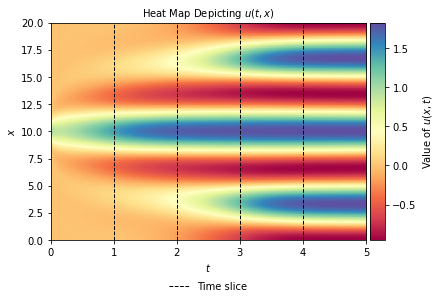

In [16]:
fig, ax = plt.subplots()

# This creates the color map
h = ax.imshow(true_sol.T, interpolation='nearest', cmap='Spectral', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
# add legend for the colorbar
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(h,cax=cax)
cbar.ax.set_ylabel('Value of $u(x,t)$')

# Plot lines corresponding to the triptych below
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[40]*np.ones((2,1)), line, 'k--', linewidth = 1, label = 'Time slice')
ax.plot(t[80]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[120]*np.ones((2,1)), line, 'k--', linewidth = 1)  
ax.plot(t[160]*np.ones((2,1)), line, 'k--', linewidth = 1) 

# Set labels and titles 
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Heat Map Depicting $ u(t,x)$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)

fig.savefig('pdfHD_rolls_1_true.pdf',  bbox_inches='tight')

fig.show()

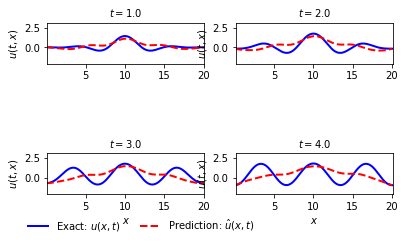

In [31]:
# initialize fig and axis
fig, ax = plt.subplots()

# set up spacing to display 4 plots
gs1 = gridspec.GridSpec(2, 2)
gs1.update(left=0.1, right=0.9, hspace=0.5)

#fig.suptitle('True and Predicted Solutions at Fixed Times')

# First Slice -- time = 1
ax = plt.subplot(gs1[0, 0])
ax.plot(x,true_sol[40,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred[40,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
#ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 1.0$', fontsize = 10)
ax.axis('square')
ax.set_xlim([0.1,20.1])
ax.set_ylim([-2.1,3.1])

# Second Slice -- time = 2
ax = plt.subplot(gs1[0, 1])
ax.plot(x,true_sol[80,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred[80,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
#ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.1,20.1])
ax.set_ylim([-2.1,3.1])
ax.set_title('$t = 2.0$', fontsize = 10)

# Third Slice -- time = 3
ax = plt.subplot(gs1[1, 0])
ax.plot(x,true_sol[120,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred[120,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.1,20.1])
ax.set_ylim([-2.1,3.1])    
ax.set_title('$t = 3.0$', fontsize = 10)

# Fourth Slice -- time - 4
ax = plt.subplot(gs1[1, 1])
ax.plot(x,true_sol[160,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred[160,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.1,20.1])
ax.set_ylim([-2.1,3.1])    
ax.set_title('$t = 4.0$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(-0.6, -0.35), ncol=5, frameon=False)

fig.savefig('pdfHD_rolls_1_slice.pdf',  bbox_inches='tight')

fig.show()

### Approximating $u(x,t)$ via Interior Data
Now we sample training points from the entire spatiotemporal domain to see if this improves our estimates. Since the boundary data has less variation than the data on the whole domain, we expect to see improved results. 

In [18]:
# Set number of training points
Num=400

# Randomly generate indices and sample Num training points
indices = np.random.choice(domain_col.shape[0], Num, replace=False)
X_u_train = domain_col[indices, :]
u_train = u_col[indices,:]

# Get collocation points
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))

#### Initialize and Train the Neural Network

Now we can initialize and train the model with the new training data. We keep the network architecture the same. 

In [19]:
# Initialize the model
model = NN.PINN(X_u_train, u_train, X_f_train, layers, lb, ub, mu, nu, False)

In [20]:
# Train the model
model.train(0, False)

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000174
  Number of iterations: 7172
  Number of functions evaluations: 7911


In [21]:
# Use the model to predict u and f on the whole domain
u_pred_all, f_pred = model.predict(domain_col, False)

In [22]:
# print errors
error_u = np.linalg.norm(u_col-u_pred_all,2)
print('Relative Error of u: %e' % (error_u/np.linalg.norm(u_col,2)))
print('Error of u: %e' % (error_u))

u_pred_all = griddata(domain_col, u_pred_all.flatten(), (X,T), method='cubic')
error = np.abs(true_sol - u_pred_all)
max_error=np.amax(error)
print('The largest pointwise error is %e' % (max_error))

Relative Error of u: 1.081777e-02
Error of u: 2.776915e+00
The largest pointwise error is 1.866049e-01


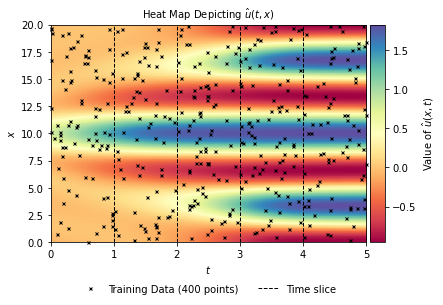

In [23]:
# Plot exactly as before 

fig, ax = plt.subplots()

# This creates the color map
h = ax.imshow(u_pred_all.T, interpolation='nearest', cmap='Spectral', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(h,cax=cax)
cbar.ax.set_ylabel('Value of $\hat u(x,t)$')

# Plot the training data (boundary data)
ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Training Data (%d points)' % (u_train.shape[0]), markersize=3,  clip_on = False)

# Plot lines corresponding to the triptych below
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[40]*np.ones((2,1)), line, 'k--', linewidth = 1, label = 'Time slice')
ax.plot(t[80]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[120]*np.ones((2,1)), line, 'k--', linewidth = 1)    
ax.plot(t[160]*np.ones((2,1)), line, 'k--', linewidth = 1) 

# Set labels and titles 
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Heat Map Depicting $\hat u(t,x)$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)
fig.savefig('pdfHD_rolls_1_pred_int.pdf',  bbox_inches='tight')

fig.show()

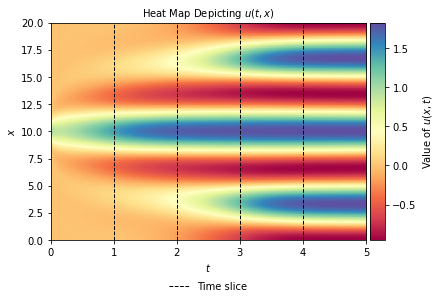

In [24]:
# Plot as before
fig,ax = plt.subplots()

# This creates the color map
h = ax.imshow(true_sol.T, interpolation='nearest', cmap='Spectral', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(h,cax=cax)
cbar.ax.set_ylabel('Value of $u(x,t)$')

# Plot lines corresponding to the triptych below
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[40]*np.ones((2,1)), line, 'k--', linewidth = 1, label = 'Time slice')
ax.plot(t[80]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[120]*np.ones((2,1)), line, 'k--', linewidth = 1)    
ax.plot(t[160]*np.ones((2,1)), line, 'k--', linewidth = 1)    

# Set labels and titles 
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Heat Map Depicting $ u(t,x)$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)

fig.show()

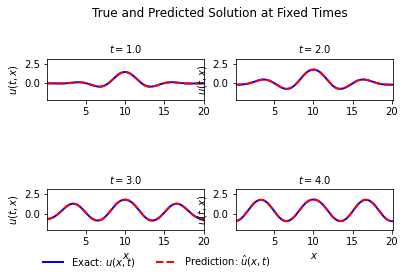

In [32]:
# Plot as before
fig, ax = plt.subplots()

gs1 = gridspec.GridSpec(2, 2)
gs1.update(left=0.1, right=0.9, hspace=0.5)

fig.suptitle('True and Predicted Solution at Fixed Times')

# First Slice
ax = plt.subplot(gs1[0, 0])
ax.plot(x,true_sol[40,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred_all[40,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
#ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 1.0$', fontsize = 10)
ax.axis('square')
ax.set_xlim([0.1,20.1])
ax.set_ylim([-2.1,3.1])

# Second Slice
ax = plt.subplot(gs1[0, 1])
ax.plot(x,true_sol[80,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred_all[80,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
#ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.1,20.1])
ax.set_ylim([-2.1,3.1])
ax.set_title('$t = 2.0$', fontsize = 10)

# Third Slice
ax = plt.subplot(gs1[1, 0])
ax.plot(x,true_sol[120,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred_all[120,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.1,20.1])
ax.set_ylim([-2.1,3.1])    
ax.set_title('$t = 3.0$', fontsize = 10)

# Fourth Slice
ax = plt.subplot(gs1[1, 1])
ax.plot(x,true_sol[160,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred_all[160,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.1,20.1])
ax.set_ylim([-2.1,3.1])    
ax.set_title('$t = 4.0$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(-0.5, -0.35), ncol=5, frameon=False)

fig.savefig('pdfHD_rolls_1_int_slice.pdf',  bbox_inches='tight')

fig.show()

### Approximating $u(t,x)$ with Interior and Boundary Data
We now take $200$ points from the boundary and $200$ points from the interior of the domain. 

#### Initialize and Train the Model
First we assemble the collection of boundary and interior data. We keep choose the same network architecture as in the previous experiments. 

In [26]:
# number of training points to sample from the boundary
Num_boundary=200

# organize boundary daata
ic1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
u1 = true_sol[0:1,:].T
ic2 = np.hstack((X[:,0:1], T[:,0:1]))
u2 = true_sol[:,0:1]
ic3 = np.hstack((X[:,-1:], T[:,-1:]))
u3 = true_sol[:,-1:]

X_u_bound = np.vstack([ic1, ic2, ic3])
u_bound = np.vstack([u1, u2, u3])

# Sample num_boundary points to be training data 
indices = np.random.choice(X_u_bound.shape[0], Num_boundary, replace=False)
X_b_train = X_u_bound[indices, :]
u_b_train = u_bound[indices,:]

Now we can assemble the collection of interior data. 

In [27]:
# Choose the number of interior training points
Num_interior=200

# Sample num_interior points to be the training data
indices = np.random.choice(domain_col.shape[0], Num_interior, replace=False)
X_int_train = domain_col[indices, :]
u_int_train = u_col[indices,:]

# Collocation points
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack([X_f_train, X_b_train, X_int_train])

X_u_train=np.vstack([X_b_train, X_int_train])
u_train=np.vstack([u_b_train, u_int_train])

In [33]:
# Initialize and train the model
model = NN.PINN(X_u_train, u_train, X_f_train, layers, lb, ub, mu, nu, False)             
model.train(0, False)

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.001059
  Number of iterations: 9017
  Number of functions evaluations: 9882


#### Results 

In [41]:
# use the model to predict u and f on the domain data
u_pred_all, f_pred = model.predict(domain_col, False)

In [42]:
# Print errors
error_u = np.linalg.norm(u_col-u_pred_all,2)
print('Relative Error of u: %e' % (error_u/np.linalg.norm(u_col,2)))
print('Error of u: %e' % (error_u))

u_pred_all = griddata(domain_col, u_pred_all.flatten(), (X,T), method='cubic')
error = np.abs(true_sol - u_pred_all)
max_error=np.amax(error)
print('The largest pointwise error is %e' % (max_error))

Relative Error of u: 1.682805e-02
Error of u: 4.319749e+00
The largest pointwise error is 1.682847e-01


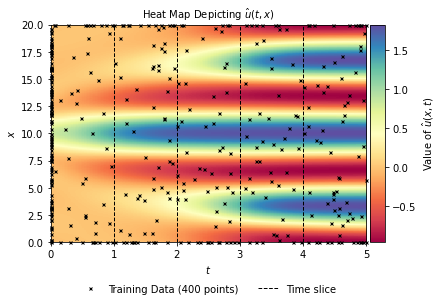

In [43]:
# Plot as before
fig, ax = plt.subplots()

# This creates the color map
h = ax.imshow(u_pred_all.T, interpolation='nearest', cmap='Spectral', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(h,cax=cax)
cbar.ax.set_ylabel('Value of $\hat u(x,t)$')

# Plot the training data (boundary data)
ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Training Data (%d points)' % (u_train.shape[0]), markersize=3,  clip_on = False)

# Plot lines corresponding to the triptych below
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[40]*np.ones((2,1)), line, 'k--', linewidth = 1, label = 'Time slice')
ax.plot(t[80]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[120]*np.ones((2,1)), line, 'k--', linewidth = 1)    
ax.plot(t[160]*np.ones((2,1)), line, 'k--', linewidth = 1) 

# Set labels and titles 
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Heat Map Depicting $\hat u(t,x)$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, frameon=False)
fig.savefig('pdfHD_rolls_1_pred_mix.pdf',  bbox_inches='tight')

fig.show()

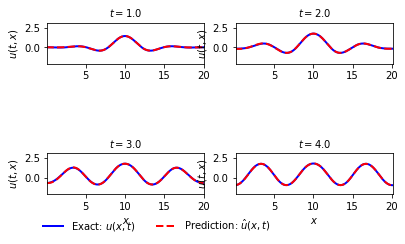

In [44]:
# Plot as before
fig, ax = plt.subplots()

gs1 = gridspec.GridSpec(2, 2)
gs1.update(left=0.1, right=0.9, hspace=0.5)

#fig.suptitle('True and Predicted Solution at Fixed Times')

# First Slice
ax = plt.subplot(gs1[0, 0])
ax.plot(x,true_sol[40,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred_all[40,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
#ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 1.0$', fontsize = 10)
ax.axis('square')
ax.set_xlim([0.1,20.1])
ax.set_ylim([-2.1,3.1])

# Second Slice
ax = plt.subplot(gs1[0, 1])
ax.plot(x,true_sol[80,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred_all[80,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
#ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.1,20.1])
ax.set_ylim([-2.1,3.1])
ax.set_title('$t = 2.0$', fontsize = 10)

# Third Slice
ax = plt.subplot(gs1[1, 0])
ax.plot(x,true_sol[120,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred_all[120,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.1,20.1])
ax.set_ylim([-2.1,3.1])    
ax.set_title('$t = 3.0$', fontsize = 10)

# Fourth Slice
ax = plt.subplot(gs1[1, 1])
ax.plot(x,true_sol[160,:], 'b-', linewidth = 2, label = 'Exact: $u(x,t)$')       
ax.plot(x,u_pred_all[160,:], 'r--', linewidth = 2, label = 'Prediction: $\hat u(x,t)$')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([0.1,20.1])
ax.set_ylim([-2.1,3.1])    
ax.set_title('$t = 4.0$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(-0.5, -0.35), ncol=5, frameon=False)

fig.savefig('pdfHD_rolls_1_mix_slice.pdf',  bbox_inches='tight')

fig.show()

## Conclusion 
The model learned best when trained on a collection of boundary and interior data, but its performance was only marginally better than the model trained on interior data. This is not necessarily surprising since training data that consists of both interior and boundary points is a more representative subset of the dynamics than training data consisting of only boundary data or only interior data, however, it is not clear that the results are statistically significant. 